# 주식 예측
* 시계열 데이터 분석 및 ARIMA Model 사용
* 삼성 전자(Samsung) 데이터 분석

|평가문항|상세기준|
|---|---|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

# 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF 
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 분해 관련
from statsmodels.tsa.stattools import adfuller # ADF
from statsmodels.tsa.arima_model import ARIMA  # ARIMA Model

In [2]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

* data를 index_cal로 함.(index를 Date로 만들어 확인)
* colums의 종류는 Date, Open, High, Low, Close, Adj Close, Volume가 있지만 close(종가)만 사용
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volumne)이 저장되어 있는 것을 확인.
* 종가(Close)만 사용. 주식시장은 정해진 기간 동안만 거래가 가능함. 종가는 하루의 장이 마감하였을 때의 가격

# 각종 전처리 수행

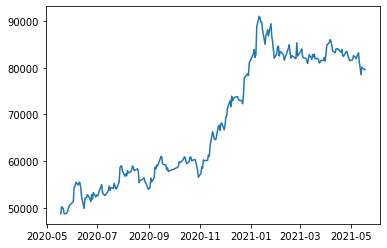

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time') # 결측값 보간
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력
plt.plot(ts)

* 보간은 비어있는 값을 주위값의 평균이나 사이값으로 채우는 것

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64


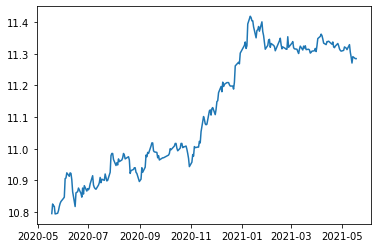

In [4]:
# 로그 변환
ts_log = np.log(ts)
print(ts_log)
print(plt.plot(ts_log))

# 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

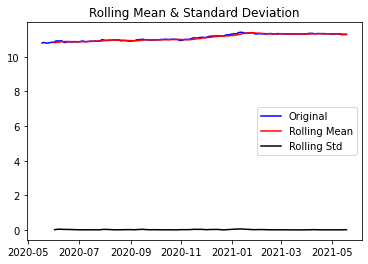

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

In [7]:
# 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

* 앞서 노드에서 사용했던 moving average 제거, differencing 등을 거치지 않고 훨씬 안정적인 시계열을 분리할 수 있음.

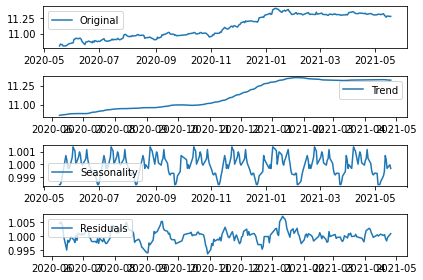

In [8]:
trend = decomposition.trend        # 추세(시간의 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid     # 원본(로그변환) - 추세 - 계절성

# 원본 / 추세(Trend) / 계절성(Seaseonality) / 잔차(Residuals) 시각화 확인
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


* p-value가 0.5이므로 귀무가설을 기각할 수 없음.
* 따라서 안정적인 시계열이 아니므로  시계열 분해를 통해 데이터를 더 안정적(starionary)인 특성을 가지도록 가공/변형을 시도
* residual에서 Nan값을 dropna로 제거
* Nan값을 제거한 residual을 ADF_test로 확인 결과 p-value 값이 매우 안정적으로 변화되었으므로 귀무가설 기각, 대립가설 채택(안정적인 시계열)

# 학습, 테스트 데이터셋 생성

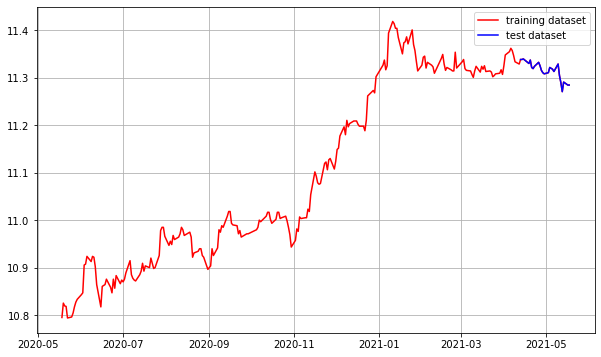

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* 주가 예측(미래에 주가를 예측)이므로 test set은 끝부분을 사용

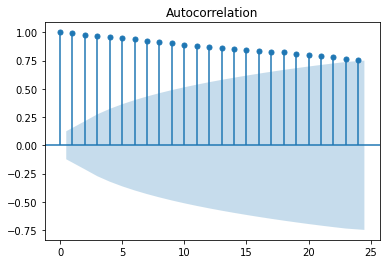

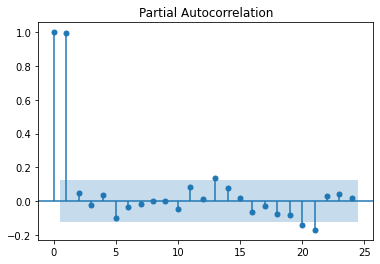

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ARIMA의 모수 p,q,d 의미
 * p : 자기회귀 모형(AR)의 시차
 * q : 이동평균 모형(MA)의 시차
 * d : 차분누적(I) 횟수
* p와 q는 일반적으로 p + q < 2, p * q = 0인 값을 사용.
 * 이는 p나 q 중에서 하나는 0이라는 뜻
 * 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문.


* ARIMA Model을 활용하기 위한 모수(p, q, d) 설정
 * 많은 통계학적 시도 중 대표적인 ACF, PACF를 사용
 * ACF(Autocrrelation Function)
   * 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
   * 주어진 시계열의 현재 값이 과거(y_t-1, y_t-2, ...., y_t-n) 값과 어떻게 상관되는지 설명함.
   * ACF plot에서 X축은 상관 계수를 나타냄, y축을 시차 수를 나타냄
 * PACF(Partial Autocorrelation Function)
   * 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
   * k 이외에 모든 시차를 갖는 관측치(y_t-1, y_t-2, ...., y_t-k+1)의 영향력을 배제한 가운데 특정 두 관측치, y_t와 y_t-k가 얼마나 관련이 있는지 나타내는 척도.

* ACF를 통해 MA 모델의 시차 q를 결정
* PACF를 통해 AR 모델의 기차 p를 결정
||AR(p)|MA(q)|
|---|---|---|
|ACF|점차적으로 감소|시차q 이후에 0|
|PACF|시차 p 이후에 0|점차적으로 감소|

* 위의 표를 참고하여 PACF 그래프를 확인했을 때 p=1이 적합하고 판단
 * p가 2 이상인 구간에서 PACF는 0에 가까워짐(아무 상관 없는 데이터, 고려X)


* 위의 표를 참고하여 ACF 그래프를 확인했을 때
 * 점차적인 감소
 * AR(1) 모델에 유사한 형태를 보임


* q는 적합한 값이 없어보임. AR을 고려했기 때문에 MA는 고려할 필요가 없음.
* q=0으로 두고 q값을 바꿔보며 확인 해보기


* d는 d차 차분을 구해서 시계열이 안정된 상태인지 확인 필요

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


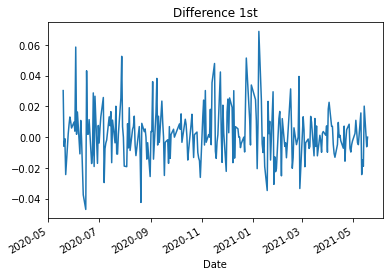

In [12]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

* p-value의 값이 아주 작은 값으로 나왔기 때문에 귀무가설을 기각할 수 있으며 시계열이 안정적임을 알 수 있음
* 따라서 1차 차분으로도 충분히 나왔기 때문에 2차 차분을 구할 필요가 없음.
* d는 periods에 1을 넣어서 1차(및 2차) 차분을 구한 결과 안정적으로 나왔기 때문에 1을 사용하면 된다.

# ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [13]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) # p, d, q 순서
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1164.792
Time:                        08:54:23   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

* error는 다음을 참고(중요하지 않음)
 * https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

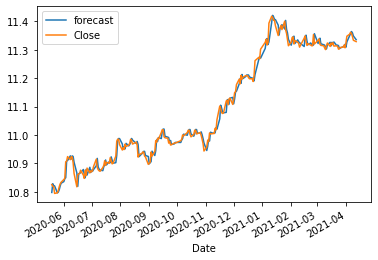

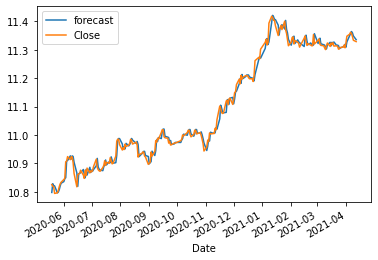

In [14]:
fitted_m.plot_predict() # 훈련 결과 확인

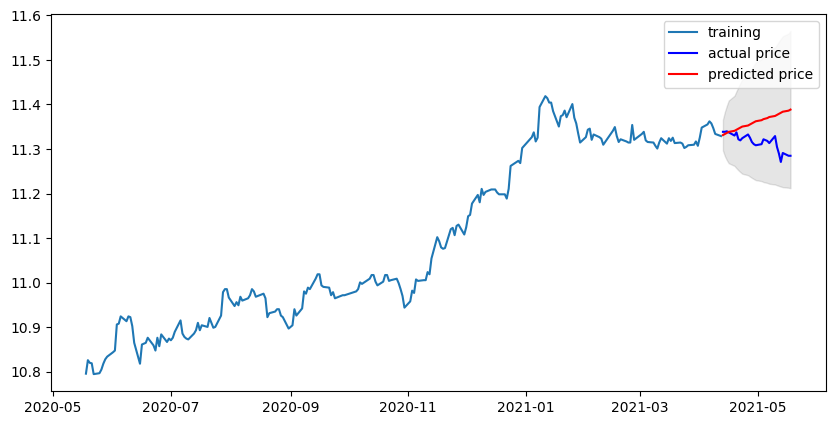

In [15]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [16]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


* 시계열 데이터를 로그 변환하였기 때문에 정확한 오차를 계산하기 위해서는 다시 지수 변환이 필요.
* np.exp()를 사용 후 MSE, MAEm RMSE, MAPE 계산

# 다른 주식 종목 예측
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

## Naver

In [17]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/naver.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    314500.0
2020-09-08    311000.0
2020-09-09    304500.0
2020-09-10    307500.0
2020-09-11    306000.0
Name: Close, dtype: float64

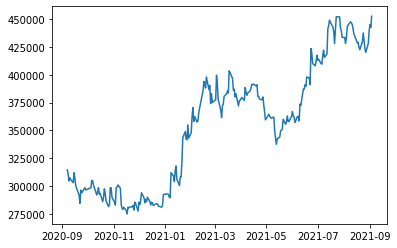

In [18]:
# 결측치 처리
ts = ts.interpolate(method='time') # 결측값 보간
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력
plt.plot(ts)

In [19]:
# 로그 변환
ts_log = np.log(ts)
print(ts_log)

Date
2020-09-07    12.658739
2020-09-08    12.647548
2020-09-09    12.626426
2020-09-10    12.636230
2020-09-11    12.631340
                ...    
2021-08-30    12.966878
2021-08-31    12.992255
2021-09-01    13.005830
2021-09-02    13.000196
2021-09-03    13.022543
Name: Close, Length: 247, dtype: float64


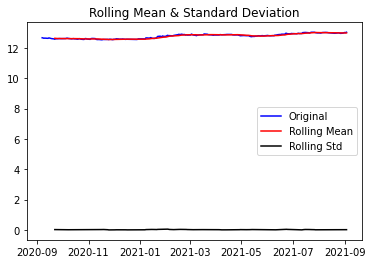

Results of Dickey-Fuller Test:
Test Statistic                  -0.357588
p-value                          0.916943
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


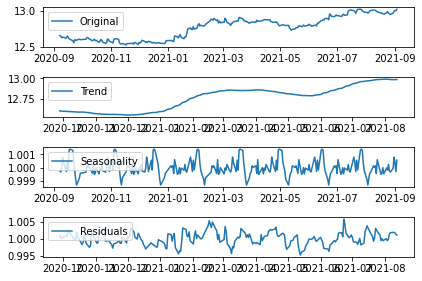

In [20]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend        # 추세(시간의 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid     # 원본(로그변환) - 추세 - 계절성

# 원본 / 추세(Trend) / 계절성(Seaseonality) / 잔차(Residuals) 시각화 확인
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [21]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.578795e+00
p-value                        7.605933e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


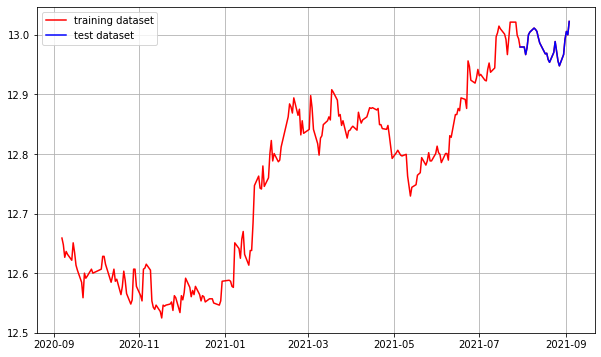

In [22]:
# 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

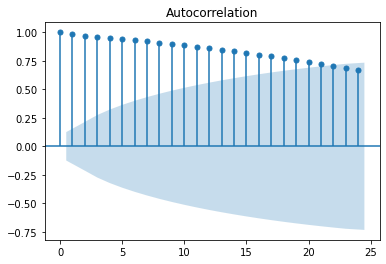

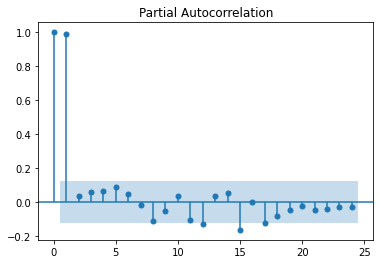

In [23]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.266271e+01
p-value                        1.294516e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


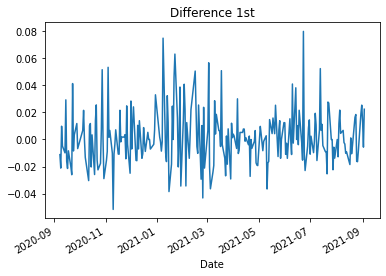

In [24]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [25]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) # p, d, q 순서
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 542.966
Method:                       css-mle   S.D. of innovations              0.021
Date:                Sun, 05 Sep 2021   AIC                          -1079.932
Time:                        08:54:26   BIC                          -1069.737
Sample:                             1   HQIC                         -1075.815
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      1.120      0.263      -0.001       0.004
ar.L1.D.Close    -0.0297      0.067     -0.442      0.658      -0.161       0.102
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

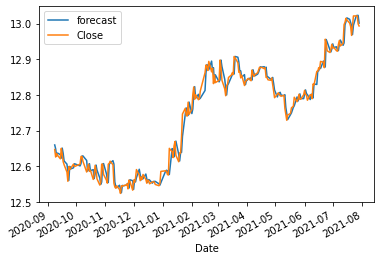

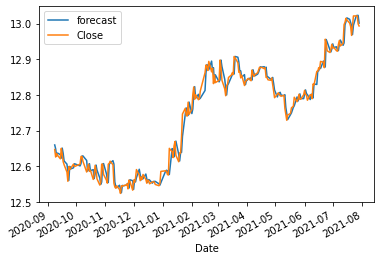

In [26]:
fitted_m.plot_predict() # 훈련 결과 확인

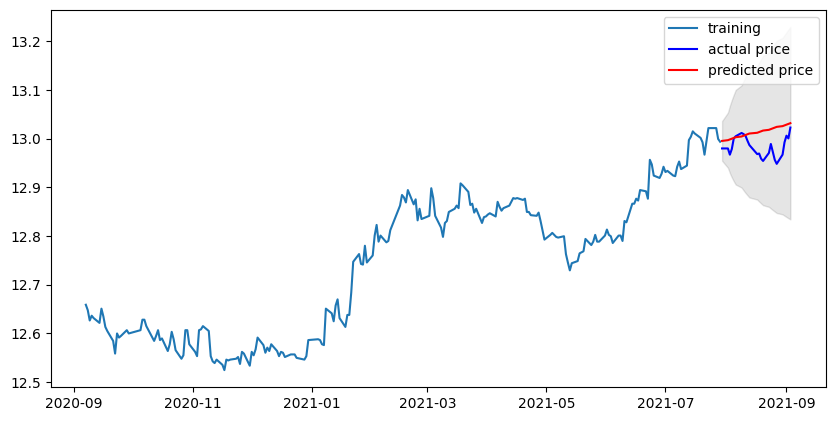

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [28]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  273121371.38867277
MAE:  13484.391961321118
RMSE:  16526.384099030034
MAPE: 3.14%


## Kakao

In [29]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/kakao.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    78400.0
2020-09-08    78000.0
2020-09-09    76800.0
2020-09-10    77100.0
2020-09-11    75800.0
Name: Close, dtype: float64

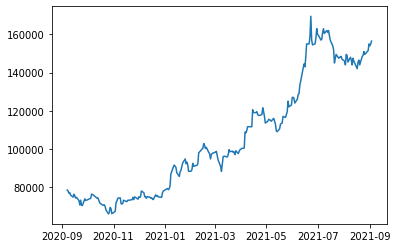

In [30]:
# 결측치 처리
ts = ts.interpolate(method='time') # 결측값 보간
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력
plt.plot(ts)

In [31]:
# 로그 변환
ts_log = np.log(ts)
print(ts_log)

Date
2020-09-07    11.269579
2020-09-08    11.264464
2020-09-09    11.248960
2020-09-10    11.252859
2020-09-11    11.235854
                ...    
2021-08-30    11.928341
2021-08-31    11.951180
2021-09-01    11.944708
2021-09-02    11.951180
2021-09-03    11.960811
Name: Close, Length: 247, dtype: float64


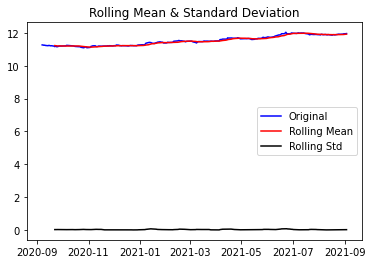

Results of Dickey-Fuller Test:
Test Statistic                   0.007583
p-value                          0.959155
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


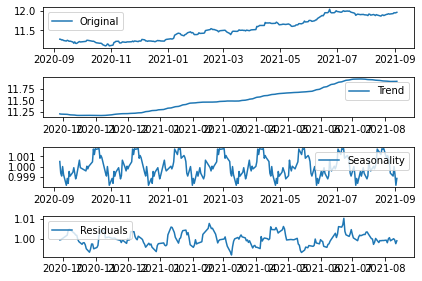

In [32]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend        # 추세(시간의 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid     # 원본(로그변환) - 추세 - 계절성

# 원본 / 추세(Trend) / 계절성(Seaseonality) / 잔차(Residuals) 시각화 확인
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [33]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.243341
p-value                          0.000007
#Lags Used                       1.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


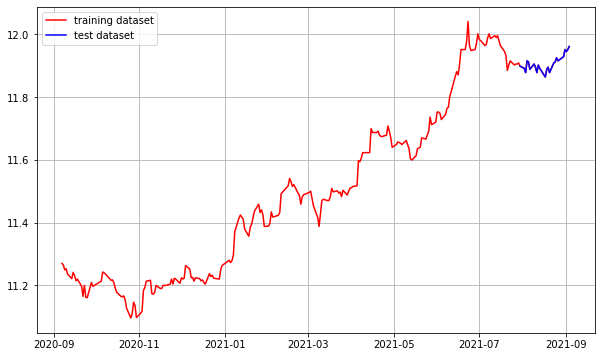

In [34]:
# 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

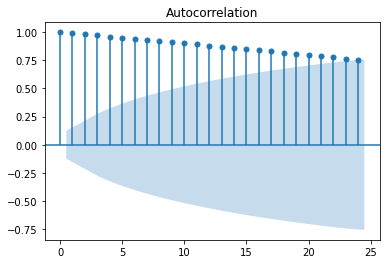

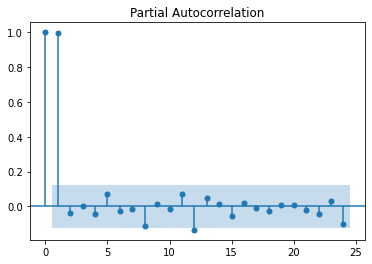

In [35]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.468894e+01
p-value                        3.071268e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


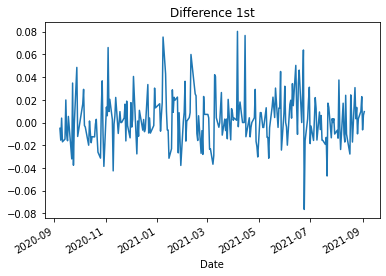

In [36]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [37]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) # p, d, q 순서
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 527.299
Method:                       css-mle   S.D. of innovations              0.022
Date:                Sun, 05 Sep 2021   AIC                          -1048.598
Time:                        08:54:29   BIC                          -1038.403
Sample:                             1   HQIC                         -1044.481
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.002      1.767      0.077      -0.000       0.006
ar.L1.D.Close     0.0842      0.067      1.258      0.208      -0.047       0.215
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

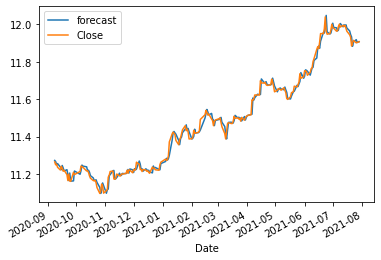

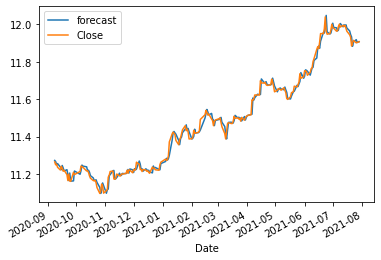

In [38]:
fitted_m.plot_predict() # 훈련 결과 확인

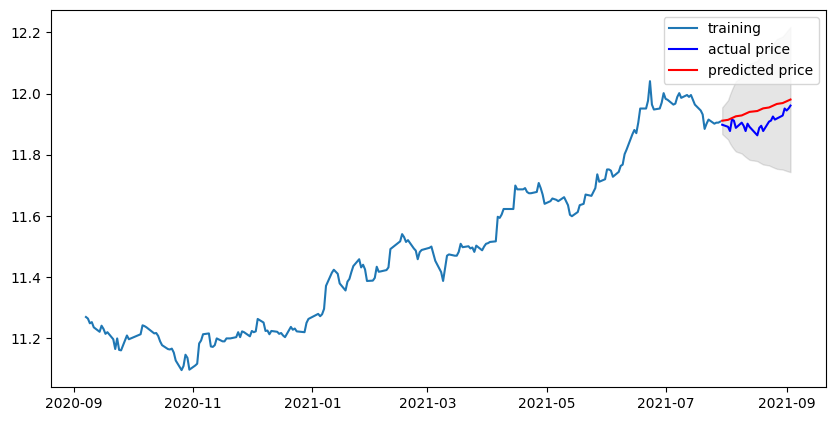

In [39]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [40]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40640627.392147645
MAE:  5779.921836155599
RMSE:  6375.00018761942
MAPE: 3.92%


## Coupang

In [41]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/coupang.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-03-11    49.250000
2021-03-12    48.470001
2021-03-15    50.450001
2021-03-16    47.130001
2021-03-17    43.290001
Name: Close, dtype: float64

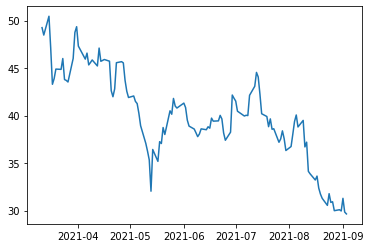

In [42]:
# 결측치 처리
ts = ts.interpolate(method='time') # 결측값 보간
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력
plt.plot(ts)

In [43]:
# 로그 변환
ts_log = np.log(ts)
print(ts_log)

Date
2021-03-11    3.896909
2021-03-12    3.880945
2021-03-15    3.920983
2021-03-16    3.852910
2021-03-17    3.767922
                ...   
2021-08-30    3.404193
2021-08-31    3.399863
2021-09-01    3.443299
2021-09-02    3.396185
2021-09-03    3.389462
Name: Close, Length: 124, dtype: float64


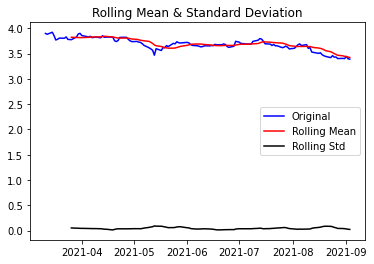

Results of Dickey-Fuller Test:
Test Statistic                  -0.626139
p-value                          0.864966
#Lags Used                       3.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


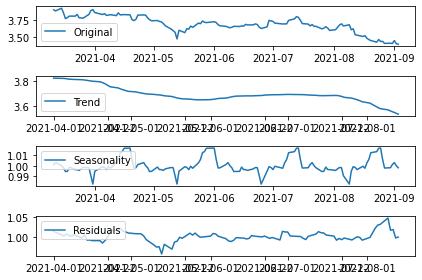

In [44]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend        # 추세(시간의 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid     # 원본(로그변환) - 추세 - 계절성

# 원본 / 추세(Trend) / 계절성(Seaseonality) / 잔차(Residuals) 시각화 확인
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                 -4.561353
p-value                         0.000152
#Lags Used                      2.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


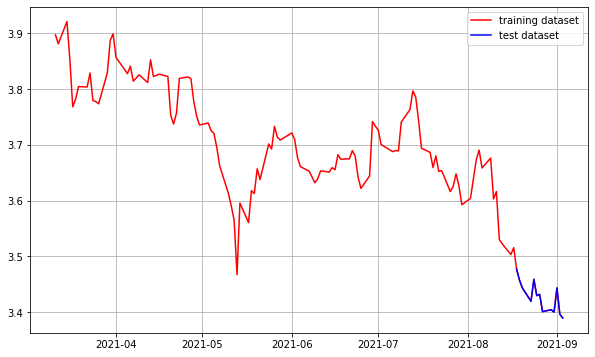

In [46]:
# 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

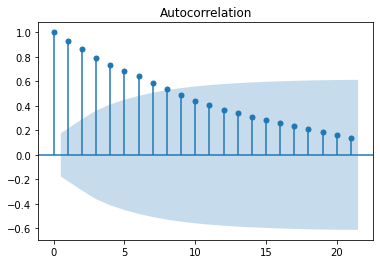

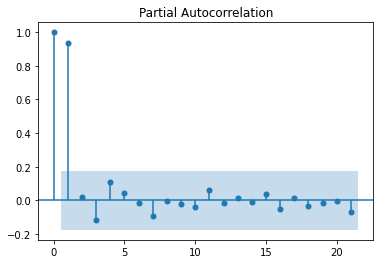

In [47]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.500909e+00
p-value                        4.256146e-11
#Lags Used                     2.000000e+00
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


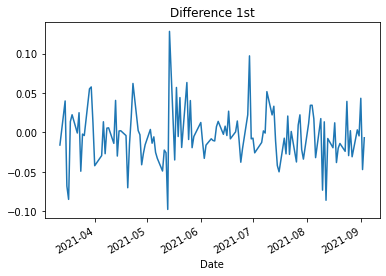

In [48]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [49]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) # p, d, q 순서
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  110
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 213.213
Method:                       css-mle   S.D. of innovations              0.035
Date:                Sun, 05 Sep 2021   AIC                           -420.426
Time:                        08:54:31   BIC                           -412.325
Sample:                             1   HQIC                          -417.140
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0035      0.003     -1.101      0.271      -0.010       0.003
ar.L1.D.Close    -0.0547      0.095     -0.576      0.565      -0.241       0.131
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

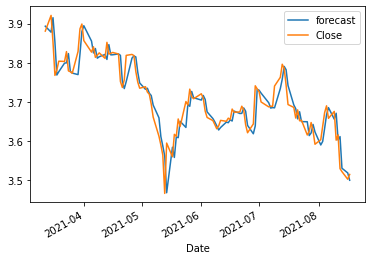

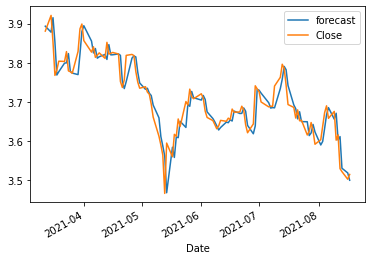

In [50]:
fitted_m.plot_predict() # 훈련 결과 확인

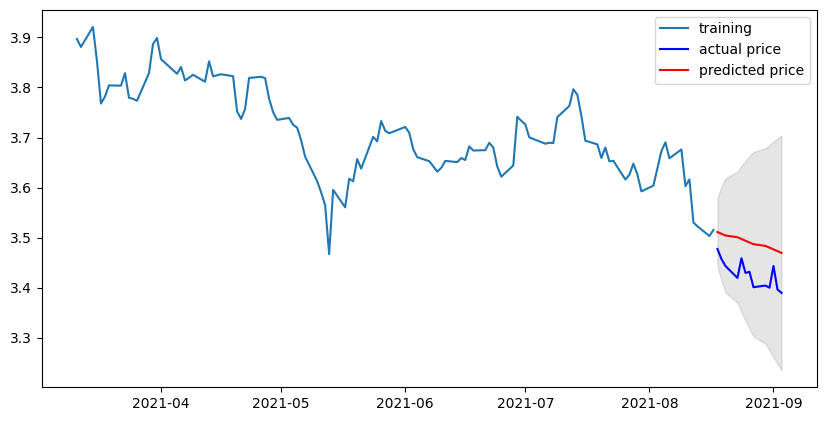

In [51]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [52]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.3273953275408115
MAE:  2.003556249534786
RMSE:  2.0802392476685974
MAPE: 6.55%


# 정리

* naver / kakao / coupang을 선정하여 분석해보았다.
* MAPE 15% 미만 달성
 * 전체 데이터
   * naver : 26.02 (2002.10-2021.09)
   * kakao : 48.12 (2000.02-2021.09)
   * coupang :6.55 (2021.03-2021.09)
 * 2020년도 이후 데이터
   * naver 3.14   (2020.09-2021.08)  
   * kakao 3.92   (2020.09-2021.08)
   * coupang 6.65 (2021.03-2021.09)
* 3개 다 ACF와 PACF를 시각화 했을 때 p, d, q는 앞의 멜버른 일일 최소온도 변화와 삼성 주가예측과 매우 비슷하게 나왔다. 그래서 똑같이 p=1, d=1, q=0으로 설정했다.
* 의문점은 왜 다 ACF와 PACF가 비슷하게 나왔는지 궁금하다.
* d를 구할 때 별도의 2차 차분없이 p-value의 값이 0 또는 낮은 값을 보여주었고 1차 차분으로 시계열 데이터의 안정성을 확인할 수 있었다.
* 모델이 예측을 할 때 구간별로 세세한 예측은 할 수 없는 것 같다.
* n년치의 데이터로 예측을 했을 때 naver와 kakao는 MAPE가 높게 나왔다. naver와 kakao는 과거의 데이터를 확인했을 때 주가가 많이 낮았다가 폭등한 경우인데 모델이 과거의 데이터를 바탕으로 예측을 하기 때문에 안정성에서 문제가 있다고 생각을 했고 따라서 MAPE가 높게 나타난 것으로 사료된다.
* coupang은 상장된지 얼마 안지났기 때문에 과거의 데이터가 없었으며 하락세를 보이고 있는데 MAPE를 확인해본 결과 오차가 별로 나지 않았음을 확인할 수 있었다.
* naver와 kakao, coupang을 참고하여 2020년도 이후의 데이터를 사용하여 MAPE를 확인했을 때 오차가 크게 나지 않았음을 확인할 수 있었다.(최근 1년치의 데이터 사용)
* 과거의 데이터부터 현재까지를 보면 지표를 변동시키는 데 당장 보이는 주가 지표로는 확인할 수 없는 여러 변수들이 많음을 알 수 있었다.
* 코로나 이전과 이후의 데이터를 각각 예측한 결과를 통해 주가 변화를 본다면 또 다른 점을 찾을 수 있지 않을까라는 생각도 해볼 수 있었다.